# Import Libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.optimizer import Optimizer, required
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import copy
import matplotlib.gridspec as gridspec    
import os
from tqdm import tqdm
from itertools import chain

## Choose the batch size

In [49]:
nEpoch = 30
batch_size = 1 #replace it with 8 if you want to compare optimizers for minibatch size 8

## Dataset creation

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(image_dim))])
train_set = torchvision.datasets.MNIST(root='./data/MNIST', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)

# Define Architecture

In [5]:
# 
class Encoder(nn.Module):

    def __init__(self, input_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 500)  #layer with 1000 nodes is removed
        self.fc3 = nn.Linear(500, 250)
        self.fc4 = nn.Linear(250, 30)
             
    def forward(self, x):
        out = self.fc1(x)
        out = torch.sigmoid(out)
        out = self.fc3(out)
        out = torch.sigmoid(out)
        out = self.fc4(out)
        return out

class Decoder(nn.Module):

    def __init__(self, input_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 250)
        self.fc2 = nn.Linear(250, 500)   #layer with 1000 nodes is removed
        self.fc4 = nn.Linear(500, 784)

    def forward(self, x):
        out = self.fc1(x)
        out = torch.sigmoid(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        out = self.fc4(out)
        out = torch.sigmoid(out)
        return out
    
    
device = torch.device("cuda:0")
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

enc_dim = 30                      #given in paper
image_dim = 784                   # 28*28 size of input image flattened to 784       
enc = Encoder(image_dim).to(device)
dec = Decoder(enc_dim).to(device)

In [6]:
class AccSGD(Optimizer):
    r"""Implements the algorithm proposed in https://arxiv.org/pdf/1704.08227.pdf, which is a provably accelerated method 
    for stochastic optimization. This has been employed in https://openreview.net/forum?id=rJTutzbA- for training several 
    deep learning models of practical interest. This code has been implemented by building on the construction of the SGD 
    optimization module found in pytorch codebase.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate (required)
        kappa (float, optional): ratio of long to short step (default: 1000)
        xi (float, optional): statistical advantage parameter (default: 10)
        smallConst (float, optional): any value <=1 (default: 0.7)
    Example:
        >>> from AccSGD import *
        >>> optimizer = AccSGD(model.parameters(), lr=0.1, kappa = 1000.0, xi = 10.0)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    """

    def __init__(self, params, lr=required, kappa = 1000.0, xi = 10.0, smallConst = 0.7, weight_decay=0):
        defaults = dict(lr=lr, kappa=kappa, xi=xi, smallConst=smallConst,
                        weight_decay=weight_decay)
        super(AccSGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AccSGD, self).__setstate__(state)

    def step(self, closure=None):
        """ Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            large_lr = (group['lr']*group['kappa'])/(group['smallConst'])
            Alpha = 1.0 - ((group['smallConst']*group['smallConst']*group['xi'])/group['kappa'])
            Beta = 1.0 - Alpha
            zeta = group['smallConst']/(group['smallConst']+Beta)
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                param_state = self.state[p]
                if 'momentum_buffer' not in param_state:
                    param_state['momentum_buffer'] = copy.deepcopy(p.data)
                buf = param_state['momentum_buffer']
                buf.mul_((1.0/Beta)-1.0)
                buf.add_(-large_lr,d_p)
                buf.add_(p.data)
                buf.mul_(Beta)

                p.data.add_(-group['lr'],d_p)
                p.data.mul_(zeta)
                p.data.add_(1.0-zeta,buf)

        return loss

In [37]:
def lossfn(optimizer):    
    loss_all2 = []
    for epoch in range(nEpoch):
        losses = []
        trainloader = tqdm(train_loader)
        
        for i, data in enumerate(trainloader, 0):
            if i * batch_size >= 10000:
                break
            else:
                inputs, _ = data
                optimizer.zero_grad()

                inputs = inputs.to(device)
                z = enc(inputs)
                outputs = dec(z)

                loss = F.mse_loss(outputs, inputs, size_average=False) / inputs.shape[0]
                loss.backward()
                optimizer.step()

                # keep track of the loss and update the stats
                losses.append(loss.item())
                trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)
        loss_all2.append(np.sqrt(np.mean(losses)))
    return loss_all2

# Various Gradient descent functions

In [38]:
def SGD(lr):
    optimizer = optim.SGD(chain(enc.parameters(), dec.parameters()), lr)
    return lossfn(optimizer)

In [39]:
def ADAM(batch_size, nEpoch, lr):
    optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr)
    return lossfn(optimizer)

In [40]:
def ASGD(lr, kappa, xi):
    optimizer = AccSGD(chain(enc.parameters(), dec.parameters()), lr, kappa, xi)
    return lossfn(optimizer)

In [41]:
def NAG( lr, momentum):
    optimizer = optim.SGD(chain(enc.parameters(), dec.parameters()), lr, momentum, nesterov = True)
    return lossfn(optimizer)

In [42]:
def HB(lr, momentum):
    optimizer = optim.SGD(chain(enc.parameters(), dec.parameters()), lr, momentum)
    return lossfn(optimizer)

# Train the autoencoder for various optimizers

##### The default values are given for mini-batch size = 1. Just replace it with commented values to get comparision plot for mini-batch size =8.

In [36]:
loss_SGD = SGD(lr=0.007)   #lr=0.2

In [14]:
loss_ADAM = ADAM(lr=0.0001)   #lr=0.001

In [15]:
loss_NAG = NAG(lr=0.008,momentum= 0.5)   #lr=0.1,momentum= 0.5

In [16]:
loss_HB = HB(lr=0.008, momentum=0.5)    #lr=0.1, momentum=0.5

In [21]:
loss_ASGD = ASGD(lr=0.01, kappa=100, xi=2.5)   # lr=0.1, kappa=100, xi=2.5 

# Plot of Comparison

<function matplotlib.pyplot.show(*args, **kw)>

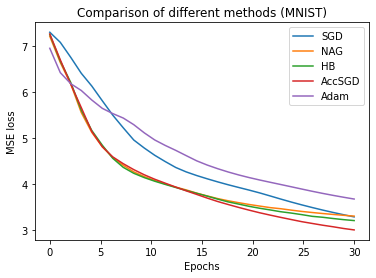

In [50]:
import matplotlib.pyplot as plt
plt.figure()
plt.title('Comparison of different methods (MNIST)')
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
x = np.linspace(0, nEpoch, nEpoch)
plt.plot(x, loss_SGD, label = 'SGD')
plt.plot(x, loss_NAG, label = 'NAG')
plt.plot(x, loss_HB, label = 'HB')
plt.plot(x, loss_ASGD, label = 'AccSGD')
plt.plot(x, loss_ADAM, label = 'Adam')
plt.legend()
plt.savefig('Compare_'+str(nEpoch)+'.png')
plt.show